In [1]:
# imports

# standard import of pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Floats (decimal numbers) should be displayed rounded with 2 decimal places
pd.options.display.float_format = "{:,.2f}".format
# Set style for plots
plt.style.use('fivethirtyeight') 

In [3]:
# getting dataframes

%store -r final_merge

### Order Prep Time = Days needed between order_date & ready_to_be_shipped

In [4]:
final_merge.sample(2)

,order_id,order_date,state,region,ship_mode,ready_to_ship_date,pickup_date,arrival_scan_date
2245,CA-2020-104927,2020-12-22,Texas,Central,Standard Processing,NaT,2020-12-30,NaT
1706,US-2020-110646,2020-10-26,Pennsylvania,East,Standard Processing,NaT,2020-11-04,NaT


In [5]:
# Create new data frame
order_prep_time2 = final_merge.copy()

## keep only necessary columns
# new_df = old_df.filter(items=['col1', 'col2']).copy()
order_prep_time2 = order_prep_time2.filter(items=["order_date", "ready_to_ship_date"]).copy()
order_prep_time2.sample(1)

,order_date,ready_to_ship_date
1898,2017-09-30,NaT


In [6]:
order_prep_time2.size

10020

In [7]:
# show me no. of cells that ARE NULL
order_prep_time2['order_date'].isnull().sum()

0

In [8]:
# show me no. of cells that ARE NULL
order_prep_time2['ready_to_ship_date'].isnull().sum()

4806

In [9]:
# show me no. of cells that are NOT NULL
order_prep_time2['ready_to_ship_date'].notnull().sum()

204

In [10]:
# Drop rows if there are null values in column arrival scan date
order_prep_time2.dropna(subset=['ready_to_ship_date'], inplace=True)
order_prep_time2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 8 to 5003
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_date          204 non-null    datetime64[ns]
 1   ready_to_ship_date  204 non-null    datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 4.8 KB


In [11]:
# Create new column to display the calculated order prep time
order_prep_time2["order_prep_time"] = order_prep_time2["ready_to_ship_date"] - order_prep_time2["order_date"]
order_prep_time2.head(1)

,order_date,ready_to_ship_date,order_prep_time
8,2020-11-23,2020-11-30,7 days


In [12]:
# Create new column for Days in INT format in case we need this for calculating
order_prep_time2["order_prep_time_i"] = order_prep_time2["order_prep_time"].dt.days
order_prep_time2.head(1)

,order_date,ready_to_ship_date,order_prep_time,order_prep_time_i
8,2020-11-23,2020-11-30,7 days,7


In [13]:
## Want to calculate what day of week the order was made on, and shipped on - to see later if there are correlations

# Day of order
order_prep_time2["ordered_day"] = order_prep_time2["order_date"].dt.day_name()

# Day of arrival
order_prep_time2["ready_ship_day"] = order_prep_time2["ready_to_ship_date"].dt.day_name()
order_prep_time2.tail(3)

,order_date,ready_to_ship_date,order_prep_time,order_prep_time_i,ordered_day,ready_ship_day
4913,2020-11-20,2020-11-24,4 days,4,Friday,Tuesday
4997,2020-11-30,2020-12-03,3 days,3,Monday,Thursday
5003,2020-11-25,2020-11-30,5 days,5,Wednesday,Monday


In [14]:
%store order_prep_time2

Stored 'order_prep_time2' (DataFrame)


``` 
Order received (Day 1) - order processed in the warehouse and made ready to ship (normally 2 days) - order leaves warehouse in the truck the following day
```

### What is the difference between expectation vs reality of prep time?

In [15]:
# need to calc the expected prep finish (order day + 3) using DateOffSet method
order_prep_time2["expect_prep_finish"] = order_prep_time2["order_date"]+pd.DateOffset(days=2)

# diff between expectation vs reality
order_prep_time2["prep_diff"] = order_prep_time2["ready_to_ship_date"] - order_prep_time2["expect_prep_finish"]

order_prep_time2

,order_date,ready_to_ship_date,order_prep_time,order_prep_time_i,ordered_day,ready_ship_day,expect_prep_finish,prep_diff
8,2020-11-23,2020-11-30,7 days,7,Monday,Monday,2020-11-25,5 days
17,2019-09-11,2019-09-17,6 days,6,Wednesday,Tuesday,2019-09-13,4 days
41,2020-11-26,2020-11-27,1 days,1,Thursday,Friday,2020-11-28,-1 days
80,2019-09-06,2019-09-09,3 days,3,Friday,Monday,2019-09-08,1 days
95,2020-11-10,2020-11-11,1 days,1,Tuesday,Wednesday,2020-11-12,-1 days
...,...,...,...,...,...,...,...,...
4852,2020-11-14,2020-11-16,2 days,2,Saturday,Monday,2020-11-16,0 days
4859,2019-09-24,2019-10-01,7 days,7,Tuesday,Tuesday,2019-09-26,5 days
4913,2020-11-20,2020-11-24,4 days,4,Friday,Tuesday,2020-11-22,2 days
4997,2020-11-30,2020-12-03,3 days,3,Monday,Thursday,2020-12-02,1 days


In [16]:
# Create new column for prep diff in INT 
order_prep_time2["prep_diff_i"] = order_prep_time2["prep_diff"].dt.days
#order_prep_time2.sample(5)
order_prep_time2.prep_diff_i.mean()

2.176470588235294

In [18]:
# Show me all rows with <=1 days in the PREP_DIFF column
filt_df = order_prep_time2.loc[order_prep_time2['prep_diff_i'] <= 1]

# count number of ready_ship_day values for each occurance
total_times = filt_df['prep_diff'].value_counts()

# count occurance for each region that appears to see if there are any correlations
#region_counts = filt_df['region'].value_counts()

#print("Filtered Rows:")
#print("\nTotal Ready Ship Days:", total_times)
#print("\nRegion Counts:")
#print(region_counts)
filt_df

,order_date,ready_to_ship_date,order_prep_time,order_prep_time_i,ordered_day,ready_ship_day,expect_prep_finish,prep_diff,prep_diff_i
41,2020-11-26,2020-11-27,1 days,1,Thursday,Friday,2020-11-28,-1 days,-1
80,2019-09-06,2019-09-09,3 days,3,Friday,Monday,2019-09-08,1 days,1
95,2020-11-10,2020-11-11,1 days,1,Tuesday,Wednesday,2020-11-12,-1 days,-1
151,2020-11-07,2020-11-09,2 days,2,Saturday,Monday,2020-11-09,0 days,0
194,2020-11-13,2020-11-16,3 days,3,Friday,Monday,2020-11-15,1 days,1
...,...,...,...,...,...,...,...,...,...
4555,2020-11-03,2020-11-05,2 days,2,Tuesday,Thursday,2020-11-05,0 days,0
4701,2019-09-24,2019-09-24,0 days,0,Tuesday,Tuesday,2019-09-26,-2 days,-2
4747,2019-09-02,2019-09-04,2 days,2,Monday,Wednesday,2019-09-04,0 days,0
4852,2020-11-14,2020-11-16,2 days,2,Saturday,Monday,2020-11-16,0 days,0


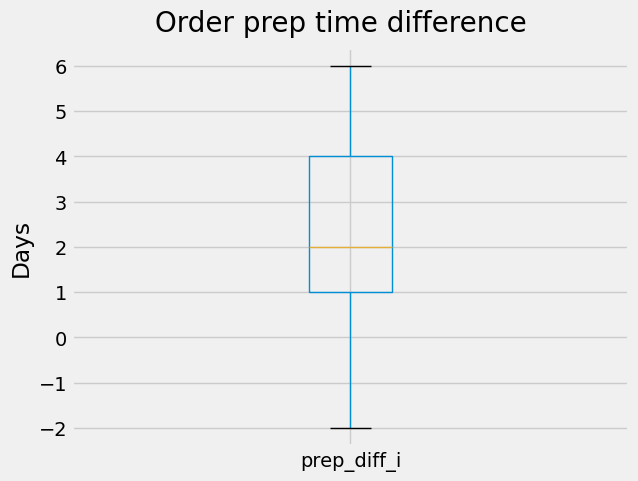

In [60]:
order_prep_time2.boxplot(column='prep_diff_i') # creates boxplot for order lead time
plt.suptitle('Order prep time difference', fontsize=20)
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots
plt.ylabel('Days');

/opt/homebrew/Caskroom/miniconda/base/envs/nf_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


''

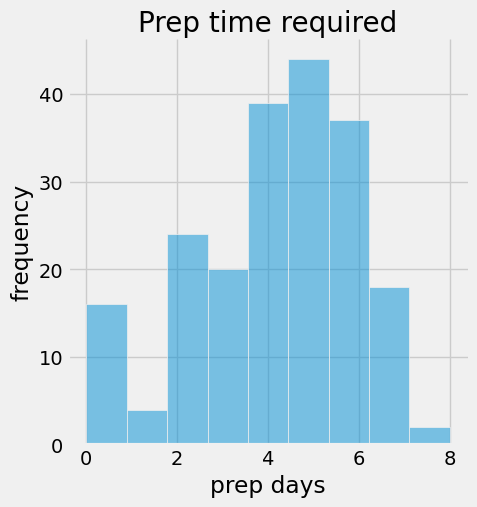

In [64]:
sns.displot(order_prep_time2[['order_prep_time_i']],legend=False)
plt.title('Prep time required', fontsize=20)
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots
plt.ylabel('frequency')
plt.xlabel('prep days')
;

### How many orders take 4 or more days prep time?


140 orders needed 4 or more days prep time. This is from a total of 204 orders

In [65]:
# Show me all rows with >=4 days in the PREP_DIFF column
filt_df2 = order_prep_time2.loc[order_prep_time2['order_prep_time_i'] >= 4]

# count number of ready_ship_day values for each occurance
#total_times = filt_df2['prep_diff_i'].value_counts()
#print("\nTotal no of orders over 4 days:", total_times)
filt_df2.shape

(140, 9)

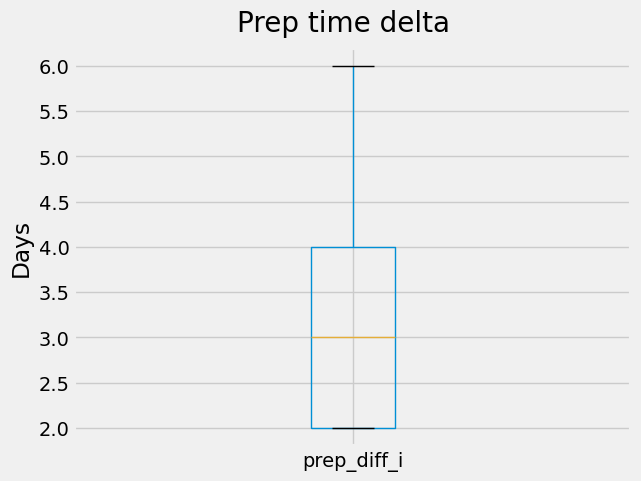

In [67]:
filt_df2.boxplot(column='prep_diff_i')                  # creates boxplot for order lead time
plt.suptitle('Prep time delta', fontsize=20)
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots
plt.ylabel('Days');

### What is the average number of days it takes from order received and ready for shipping?

In [32]:
# Mean value = 4.18 days
order_prep_time2.order_prep_time_i.mean()

4.176470588235294

In [33]:
# Describe the data
order_prep_time2.order_prep_time_i.describe()

count   204.00
mean      4.18
std       1.97
min       0.00
25%       3.00
50%       4.00
75%       6.00
max       8.00
Name: order_prep_time_i, dtype: float64

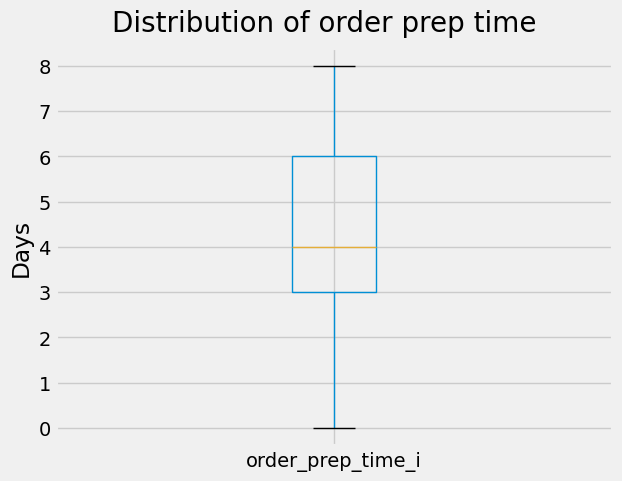

In [44]:
plt.suptitle('Distribution of order prep time', fontsize=20)
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots
order_prep_time2.boxplot(column='order_prep_time_i') # creates boxplot for order lead time
plt.ylabel('Days');

In [ ]:
# What days do the customers receive their orders?
order_prep_time2.order_prep_time_i.value_counts()